Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(42000, 784)
(28000, 784)
8


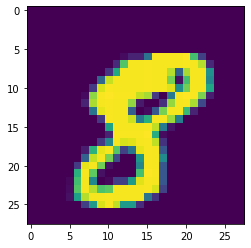

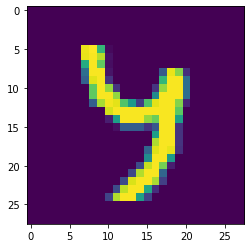

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=896, out_features=1024, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1024, out_features=10, bias=True)
  (12): Sigmoid()
)


In [53]:
import pandas as pd
import numpy as np
import torch
%matplotlib inline 
from matplotlib import pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

dt_train_path = "drive/MyDrive/Kaggle_digits/train.csv"
dt_test_path = "drive/MyDrive/Kaggle_digits/test.csv"

# open CSV with pandas, then convert to numpy and splice into data and labels
dt_train_1d = pd.read_csv(dt_train_path).values
dt_train = dt_train_1d[:, 1:]
dt_train_labels = dt_train_1d[:, 0]

# no labels in test data.
dt_test = pd.read_csv(dt_test_path).values

print(dt_train.shape)
print(dt_test.shape)

# convert 784 into 28x28
dt_train = np.reshape(dt_train, (dt_train.shape[0], 28, 28))
dt_test = np.reshape(dt_test, (dt_test.shape[0], 28, 28))

print(dt_train_labels[10])
plt.imshow(dt_train[10])
plt.show()
plt.imshow(dt_test[12])
plt.show()


# n_out = ((n_in + 2p - k) / s) + 1
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, 3, 1, 1), #28->28
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2), #28->14
    torch.nn.Conv2d(32, 64, 3, 1, 1), #14->14
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2), #14->7
    torch.nn.Conv2d(64, 128, 3, 1, 1), #7->7
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(896, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 10),
    torch.nn.Sigmoid()
)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

for epoch in range(0, 20):
  model.train()
  